In [1]:
%matplotlib inline

# Built-in
import csv
import os
import re

# Scientific/ML libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap
shap.initjs()

# IPython display
from IPython.display import Markdown, display

# Scipy
from scipy.stats import chi2_contingency

# Scikit-learn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# AIF360 fairness library
from aif360.datasets import BinaryLabelDataset
from aif360.explainers import MetricTextExplainer
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing


# Seed for reproducibility
np.random.seed(1)


C:\Users\artem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


# Load Base Cleaned/Encoded Data

In [2]:
df = pd.concat([pd.read_csv('dataset/train_test_extracted_oversample/train.csv'), pd.read_csv('dataset/train_test_extracted_oversample/val.csv')])
df.head

<bound method NDFrame.head of        race  gender  age  admission_type_id  discharge_disposition_id  \
0         3       0   75                  1                         1   
1         3       0   85                  2                        22   
2         3       0   75                  2                         2   
3         3       0   65                  1                         2   
4         3       0   75                  5                         3   
...     ...     ...  ...                ...                       ...   
10144     3       0   75                  3                         1   
10145     3       0   65                  1                         1   
10146     3       0   85                  6                        25   
10147     3       1   85                  3                         1   
10148     1       1   75                  1                        18   

       admission_source_id  time_in_hospital  medical_specialty  \
0                        7

# Correlation Visualization

In [3]:
numeric_columns = df.columns
correlation_matrix = df[numeric_columns].corr()
print(correlation_matrix)

                              race    gender       age  admission_type_id  \
race                      1.000000  0.051062  0.136184           0.089804   
gender                    0.051062  1.000000 -0.050054           0.015762   
age                       0.136184 -0.050054  1.000000          -0.009407   
admission_type_id         0.089804  0.015762 -0.009407           1.000000   
discharge_disposition_id  0.010225 -0.021903  0.110373           0.077689   
...                            ...       ...       ...                ...   
diag_3_Injury             0.008435  0.017275  0.000026           0.009175   
diag_3_Muscoloskeletal    0.005047 -0.018122 -0.004542           0.018162   
diag_3_Neoplasms          0.002362  0.017769  0.031689          -0.002288   
diag_3_Other             -0.002549 -0.011889 -0.135432          -0.022072   
diag_3_Respiratory        0.020810  0.000575  0.044472          -0.015829   

                          discharge_disposition_id  admission_source_id  \


In [4]:
# Correlation with readmitted patients
correlation_with_readmitted = df.corr()['readmitted']
sorted_correlation_readmitted = correlation_with_readmitted.abs().sort_values(ascending=False)
sorted_correlation_readmitted = sorted_correlation_readmitted[1:]
print(sorted_correlation_readmitted)

number_inpatient                     0.169057
race_Asian                           0.163076
race_Other                           0.158988
race_Hispanic                        0.145863
race_Caucasian                       0.137091
                                       ...   
glimepiride_pioglitazone_medicine    0.001365
pioglitazone_medicine                0.001162
diag_3_Other                         0.001120
diag_1_Circulatory                   0.001111
admission_source_id                  0.000083
Name: readmitted, Length: 71, dtype: float64


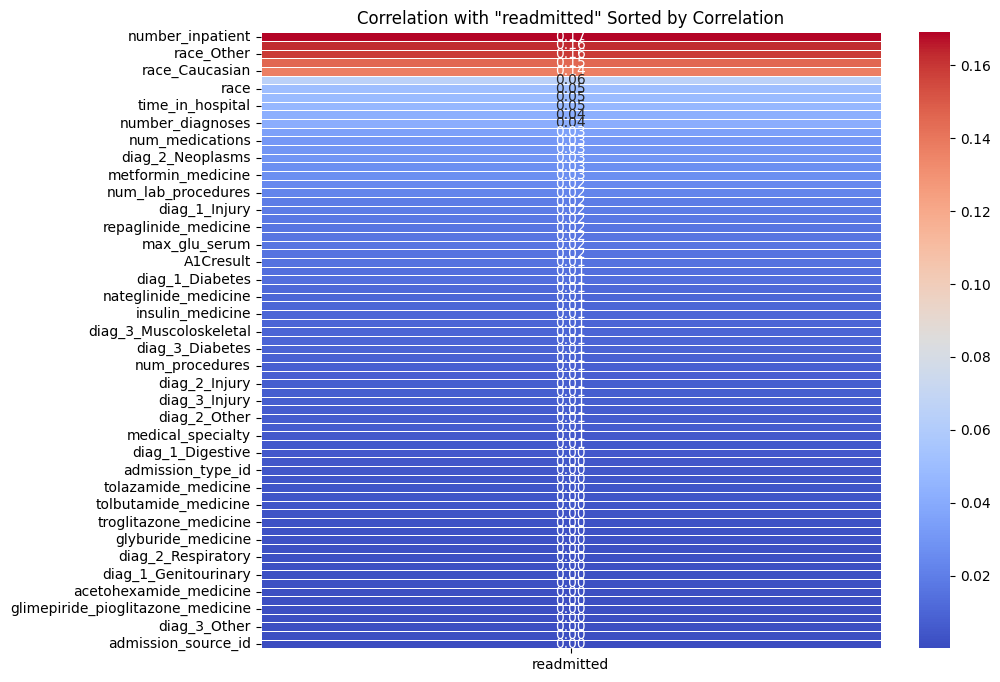

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_correlation_readmitted.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with "readmitted" Sorted by Correlation')
plt.show()

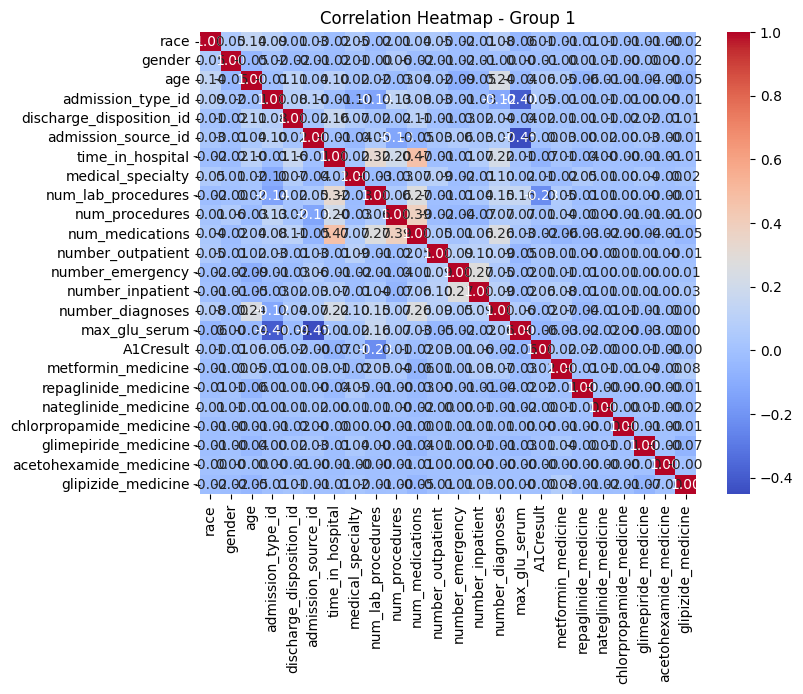

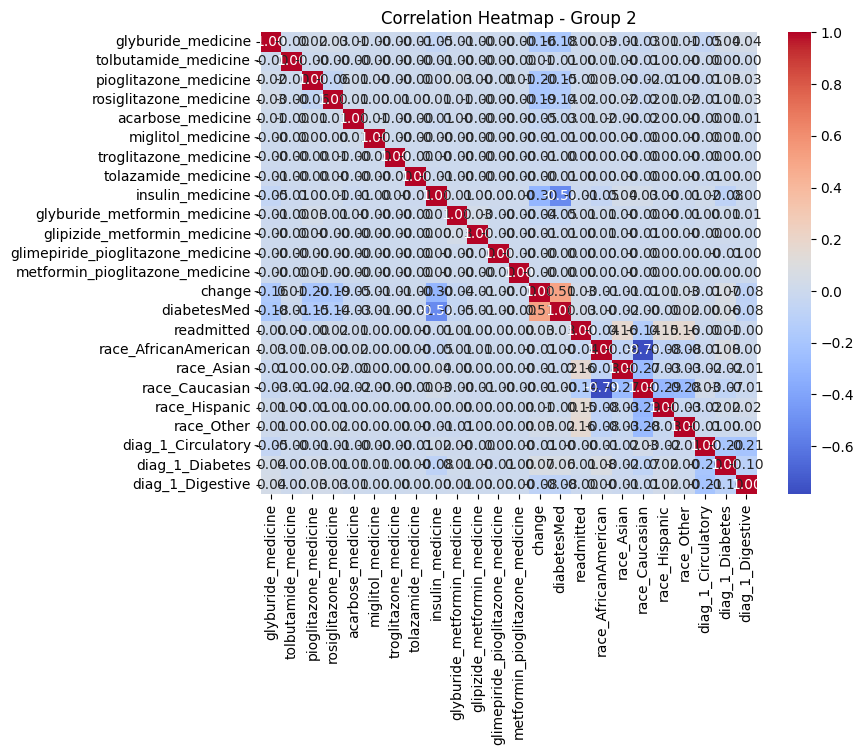

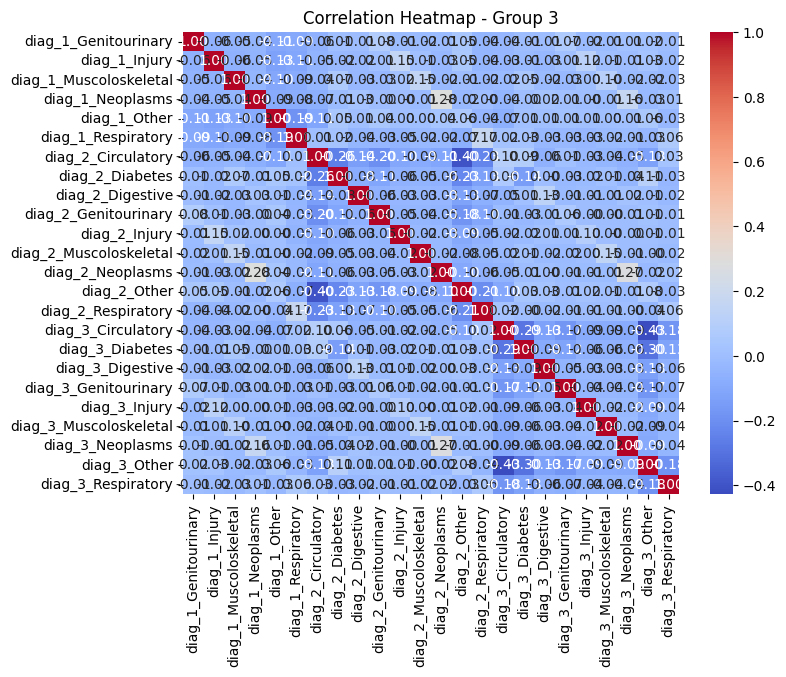

In [6]:
# Heatmap Visualization
num_columns = len(correlation_with_readmitted)
group_size = num_columns // 3  # number of columns per group

# split the columns into three groups for better visibility
group_1 = correlation_with_readmitted[:group_size].index  # first group
group_2 = correlation_with_readmitted[group_size:2*group_size].index  # second group
group_3 = correlation_with_readmitted[2*group_size:].index  # third group

group_1_matrix = df[group_1].corr()
group_2_matrix = df[group_2].corr()
group_3_matrix = df[group_3].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(group_1_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Group 1")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(group_2_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Group 2")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(group_3_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Group 3")
plt.show()

In [7]:
# # Correlation with age
# correlation_with_age = df.corr()['age']
# sorted_correlation_age = correlation_with_age.abs().sort_values(ascending=False)
# sorted_correlation_age = sorted_correlation_age[1:]
# print(sorted_correlation_age)

In [8]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(sorted_correlation_age.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title('Correlation with "age" Sorted by Correlation')
# plt.show()

In [9]:
# Correlation with race
correlation_with_race = df.corr()['race']
sorted_correlation_race = correlation_with_race.abs().sort_values(ascending=False)
sorted_correlation_race = sorted_correlation_race[1:]
print(sorted_correlation_race)

race_AfricanAmerican                 0.806698
race_Caucasian                       0.804367
race_Other                           0.465270
race_Hispanic                        0.279234
age                                  0.136184
                                       ...   
glyburide_metformin_medicine         0.001814
acetohexamide_medicine               0.001636
metformin_pioglitazone_medicine      0.001636
glimepiride_pioglitazone_medicine    0.001636
diag_1_Digestive                     0.000211
Name: race, Length: 71, dtype: float64


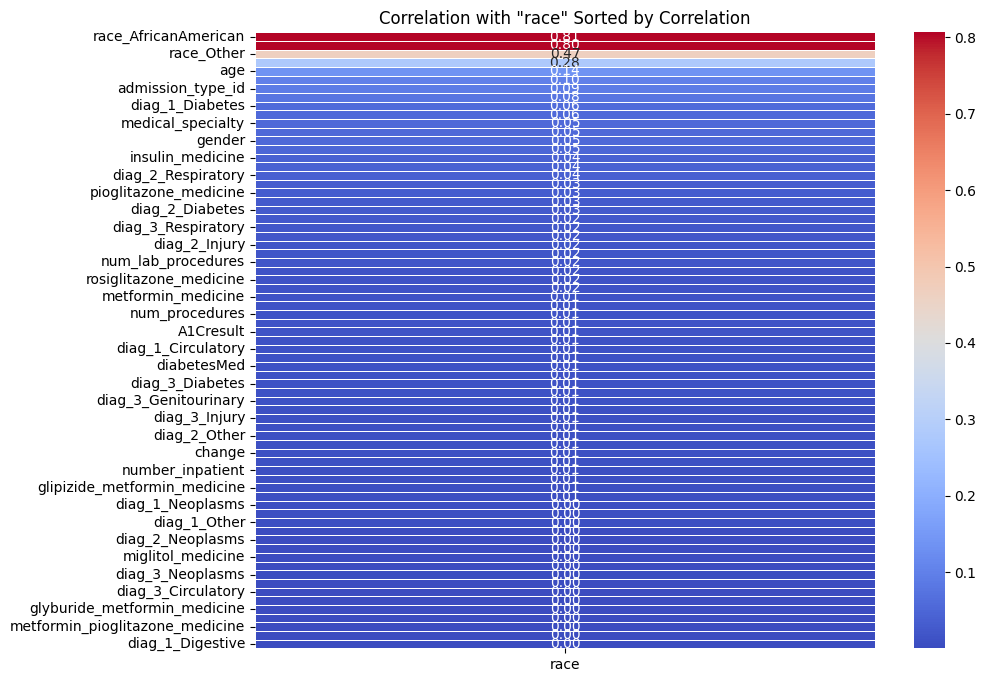

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_correlation_race.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with "race" Sorted by Correlation')
plt.show()

In [11]:
# Correlation with gender
correlation_with_gender = df.corr()['gender']
sorted_correlation_gender = correlation_with_gender.abs().sort_values(ascending=False)
sorted_correlation_gender = sorted_correlation_gender[1:]
print(sorted_correlation_gender)

race_AfricanAmerican    0.069727
num_procedures          0.063478
diag_1_Circulatory      0.055269
race                    0.051062
race_Caucasian          0.050841
                          ...   
number_diagnoses        0.001183
num_lab_procedures      0.001166
metformin_medicine      0.000802
diag_3_Respiratory      0.000575
glimepiride_medicine    0.000298
Name: gender, Length: 71, dtype: float64


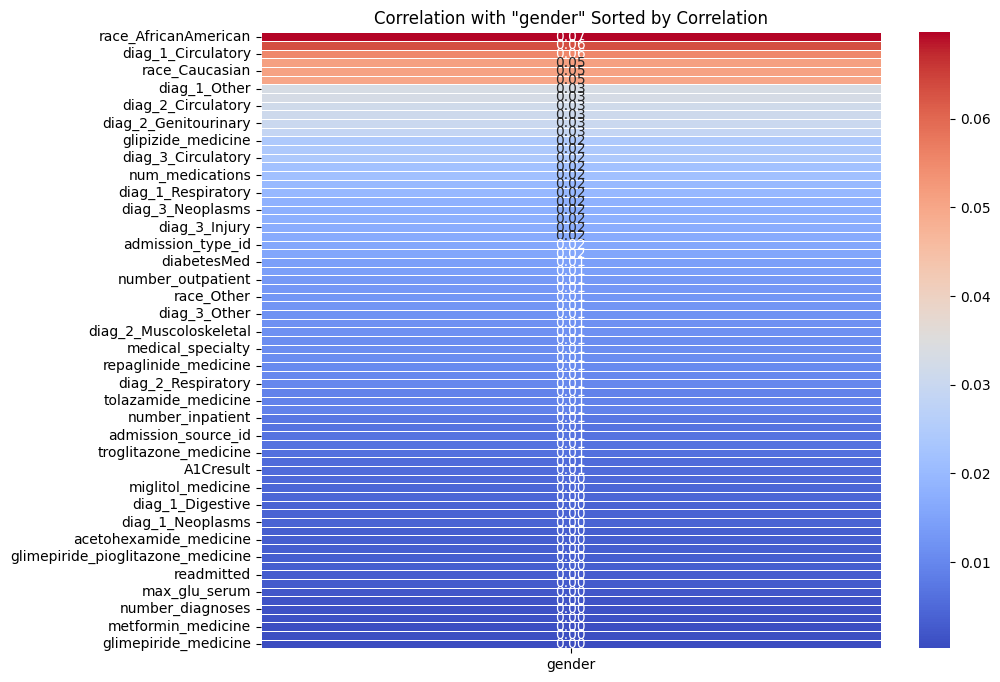

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_correlation_gender.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with "gender" Sorted by Correlation')
plt.show()

# important Feature Extraction with RF and GBM

In [13]:
# helper function for model evaluation

def evaluate_model_and_features(
    X, 
    y, 
    model, 
    feature_names=None, 
    top=20, 
    title="Model", 
    multi_output=False,
    average='binary'
):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    if multi_output:
        model = MultiOutputClassifier(model)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average)
    rec = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    print(f"\n--- {title} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    if multi_output:
        importances = np.mean(
            [est.feature_importances_ for est in model.estimators_], axis=0
        )
    else:
        importances = model.feature_importances_

    if feature_names is None:
        feature_names = np.arange(len(importances))
    else:
        feature_names = np.array(feature_names)

    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_idx]
    sorted_features = feature_names[sorted_idx]

    print(f"\nTop {top} Features by Importance:")
    for i in range(min(top, len(sorted_features))):
        print(f"{i+1}. {sorted_features[i]} ({sorted_importances[i]:.4f})")

    plt.figure(figsize=(8, 5))
    plt.barh(sorted_features[:top], sorted_importances[:top], color="royalblue")
    plt.xlabel("Feature Importance Score")
    plt.title(f"Top {top} Feature Importances - {title}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    top_feature_data = X.loc[:, sorted_features[:top]]
    corr_matrix = top_feature_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f"Correlation Heatmap of Top {top} Features - {title}")
    plt.tight_layout()
    plt.show()

    return list(sorted_features[:top])



--- Random Forest - Readmitted ---
Accuracy : 0.8948
Precision: 0.8948
Recall   : 0.8948
F1 Score : 0.8948

Top 30 Features by Importance:
1. num_lab_procedures (0.0957)
2. num_medications (0.0832)
3. time_in_hospital (0.0613)
4. number_inpatient (0.0471)
5. medical_specialty (0.0437)
6. num_procedures (0.0411)
7. discharge_disposition_id (0.0410)
8. number_diagnoses (0.0405)
9. admission_type_id (0.0287)
10. insulin_medicine (0.0273)
11. admission_source_id (0.0247)
12. race (0.0242)
13. number_outpatient (0.0204)
14. number_emergency (0.0184)
15. A1Cresult (0.0178)
16. race_Asian (0.0175)
17. diag_3_Other (0.0152)
18. diag_2_Circulatory (0.0150)
19. diag_2_Other (0.0144)
20. change (0.0144)
21. diag_3_Circulatory (0.0142)
22. diag_1_Circulatory (0.0135)
23. metformin_medicine (0.0135)
24. race_Other (0.0131)
25. glipizide_medicine (0.0129)
26. race_Caucasian (0.0123)
27. diag_1_Other (0.0121)
28. race_Hispanic (0.0117)
29. diag_3_Diabetes (0.0115)
30. race_AfricanAmerican (0.0112)


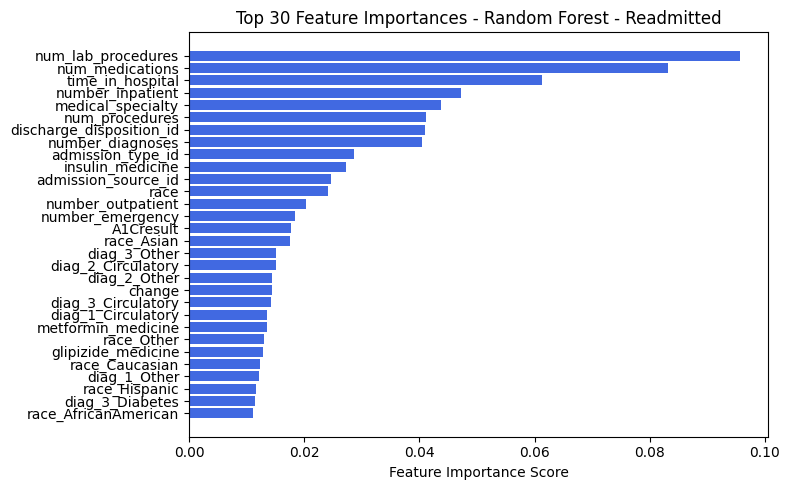

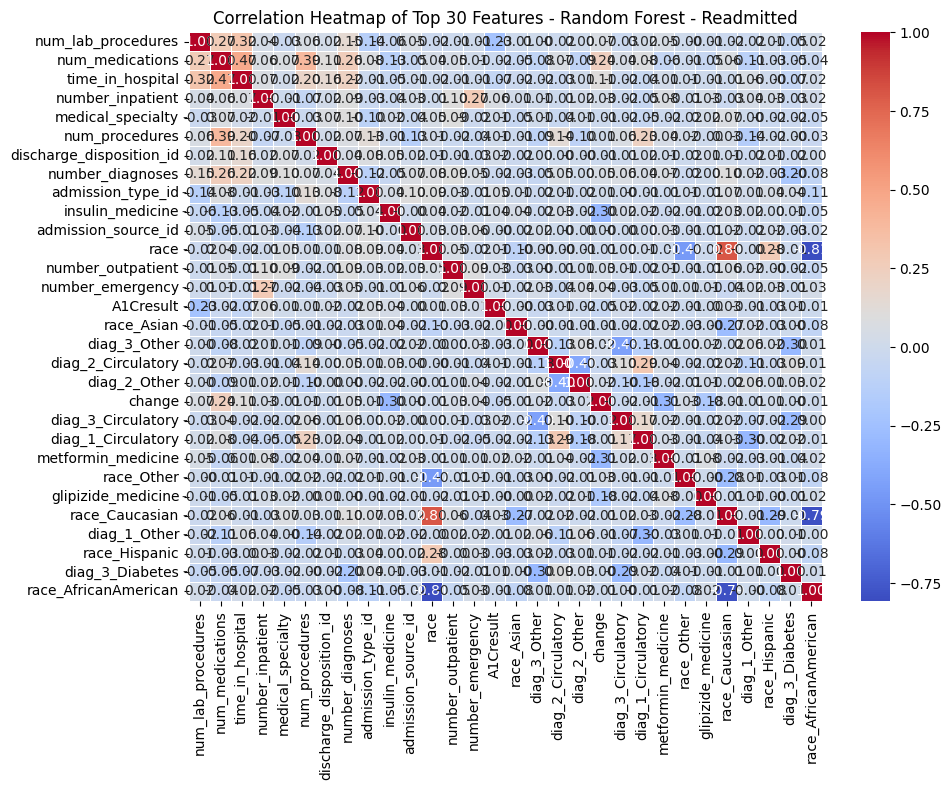

In [28]:
X_readmitted = df.drop(['readmitted', 'age', 'gender'], axis=1)
y_readmitted = df['readmitted']

rf_readmitted = RandomForestClassifier(random_state=42)

top20_features_readmitted = evaluate_model_and_features(
    X_readmitted,
    y_readmitted,
    model=rf_readmitted,
    feature_names=X_readmitted.columns,
    top=30,
    title="Random Forest - Readmitted",
    average='micro'
)



--- Random Forest - Gender ---
Accuracy : 0.6109
Precision: 0.6075
Recall   : 0.4689
F1 Score : 0.5293

Top 20 Features by Importance:
1. num_lab_procedures (0.0997)
2. num_medications (0.0884)
3. time_in_hospital (0.0638)
4. age (0.0534)
5. number_diagnoses (0.0466)
6. medical_specialty (0.0456)
7. num_procedures (0.0407)
8. number_inpatient (0.0346)
9. discharge_disposition_id (0.0328)
10. insulin_medicine (0.0303)
11. admission_type_id (0.0303)
12. admission_source_id (0.0264)
13. number_outpatient (0.0221)
14. A1Cresult (0.0204)
15. change (0.0160)
16. metformin_medicine (0.0158)
17. diag_3_Other (0.0148)
18. diag_3_Circulatory (0.0142)
19. number_emergency (0.0142)
20. diag_2_Other (0.0135)


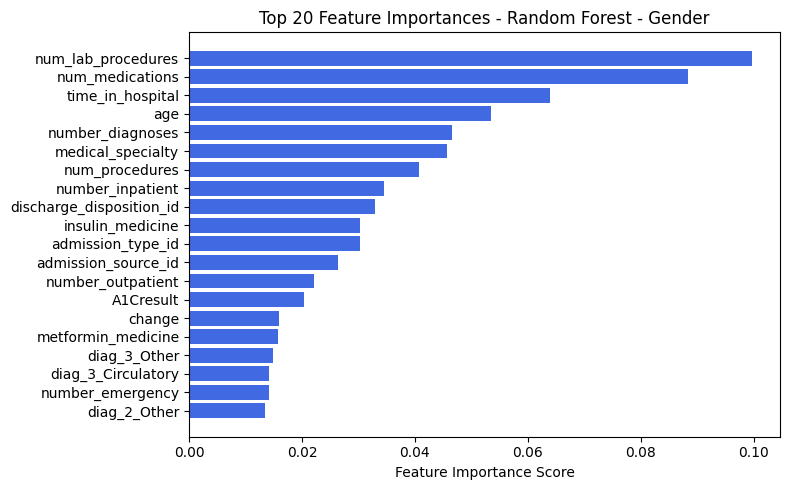

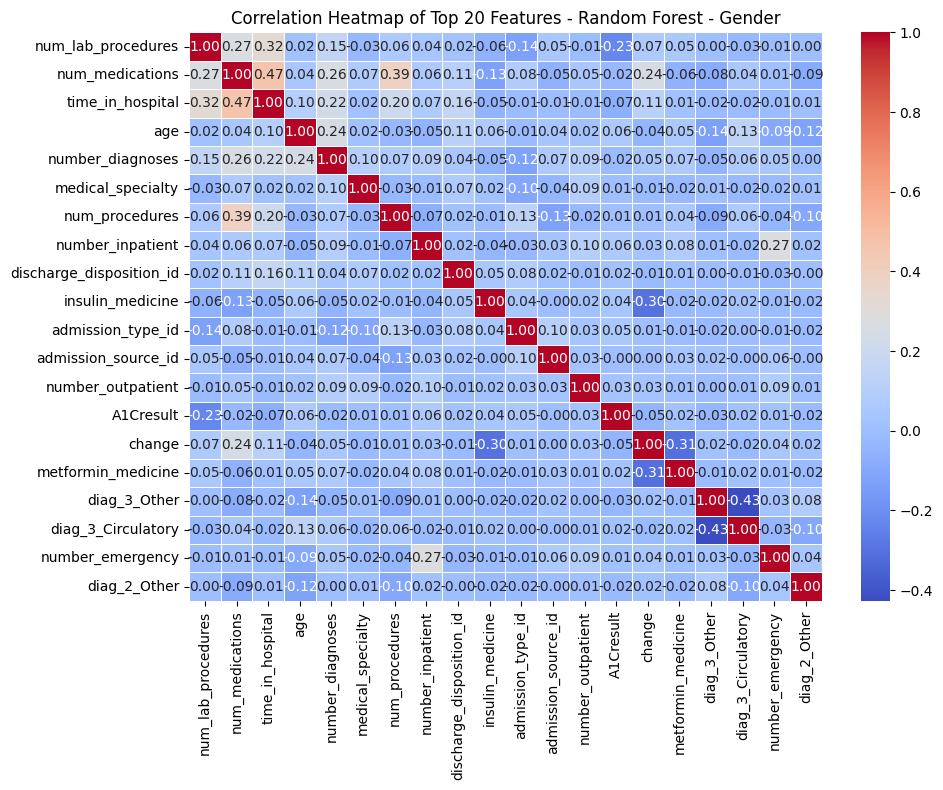

In [27]:
X_gender = df.drop(['gender'], axis=1)
y_gender = df['gender']

rfg = RandomForestClassifier(random_state=42)
top20_features_gender = evaluate_model_and_features(
    X_gender, 
    y_gender, 
    model=rfg, 
    feature_names=X_gender.columns, 
    top=20, 
    title="Random Forest - Gender", 
    multi_output=False,
    average='binary'
)


In [16]:
# X_age = df.drop(['age', 'readmitted'], axis=1)
# y_age = df['age']

# gbm_age = GradientBoostingClassifier(
#     n_estimators=100, 
#     learning_rate=0.1, 
#     max_depth=3, 
#     random_state=42
# )

# top20_features_age = evaluate_model_and_features(
#     X_age, 
#     y_age, 
#     model=gbm_age, 
#     feature_names=X_age.columns,
#     top=20,
#     title="GBM - Age",
#     multi_output=False,
#     average='micro'
# )



--- GBM - Race Labeling (Multi-class) ---
Accuracy : 0.7469
Precision: 0.7469
Recall   : 0.7469
F1 Score : 0.7469

Top 20 Features by Importance:
1. age (0.2189)
2. medical_specialty (0.1528)
3. admission_type_id (0.0868)
4. num_lab_procedures (0.0652)
5. admission_source_id (0.0539)
6. num_medications (0.0392)
7. number_diagnoses (0.0371)
8. number_outpatient (0.0321)
9. gender (0.0299)
10. number_emergency (0.0283)
11. time_in_hospital (0.0255)
12. num_procedures (0.0217)
13. insulin_medicine (0.0210)
14. discharge_disposition_id (0.0181)
15. number_inpatient (0.0111)
16. diag_1_Diabetes (0.0108)
17. diag_2_Circulatory (0.0100)
18. A1Cresult (0.0095)
19. diag_3_Circulatory (0.0088)
20. diag_2_Respiratory (0.0080)


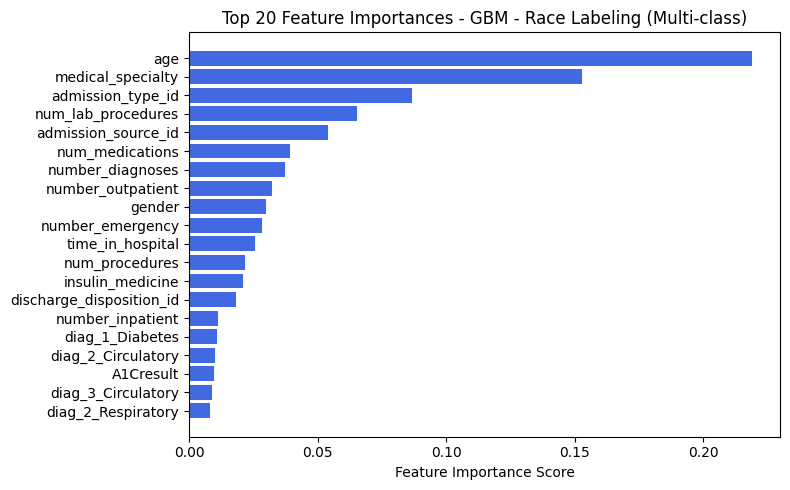

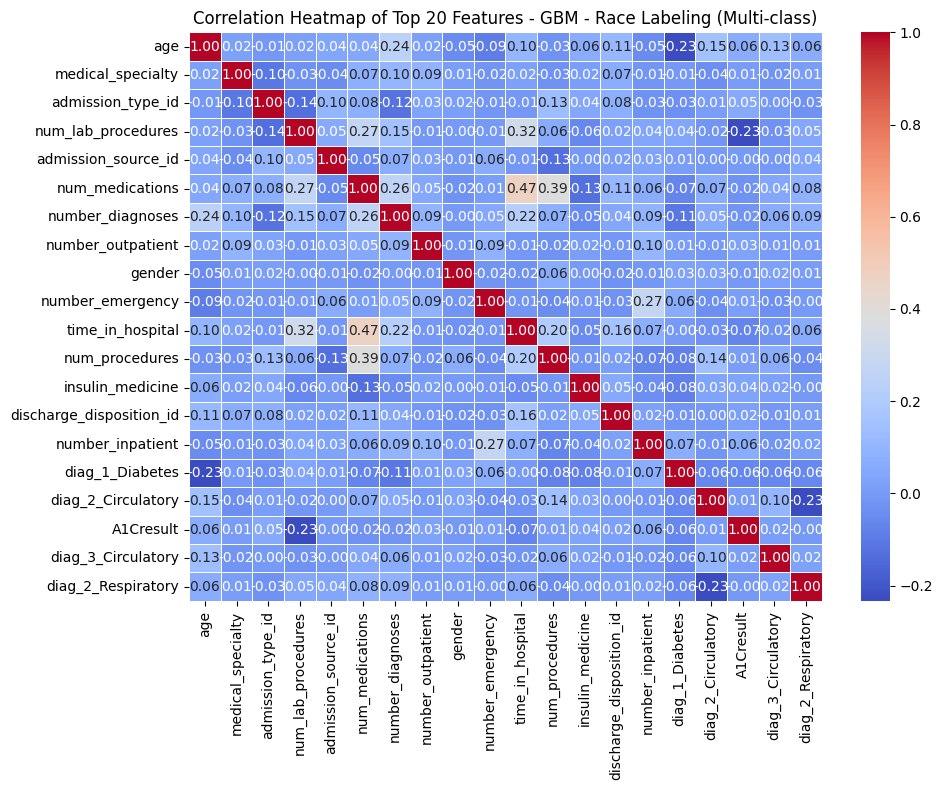

In [17]:
X_race_labeling = df.drop(
    [
        'race',
        'readmitted',
        'race_AfricanAmerican',
        'race_Asian',
        'race_Caucasian',
        'race_Hispanic',
        'race_Other',
    ],
    axis=1
)
y_race_labeling = df['race']

gbr1 = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)

top20_features_race_labeling = evaluate_model_and_features(
    X_race_labeling,
    y_race_labeling,
    model=gbr1,
    feature_names=X_race_labeling.columns,
    top=20,
    title="GBM - Race Labeling (Multi-class)",
    multi_output=False,
    average='micro'
)



--- GBM - Race (Multi-Output Binary) ---
Accuracy : 0.7302
Precision: 0.7501
Recall   : 0.7345
F1 Score : 0.7422

Top 20 Features by Importance:
1. age (0.1462)
2. medical_specialty (0.1246)
3. num_lab_procedures (0.0734)
4. admission_type_id (0.0693)
5. num_medications (0.0493)
6. number_diagnoses (0.0388)
7. admission_source_id (0.0347)
8. number_emergency (0.0340)
9. number_inpatient (0.0278)
10. discharge_disposition_id (0.0277)
11. number_outpatient (0.0259)
12. time_in_hospital (0.0252)
13. insulin_medicine (0.0207)
14. num_procedures (0.0204)
15. glipizide_medicine (0.0187)
16. gender (0.0187)
17. A1Cresult (0.0180)
18. max_glu_serum (0.0165)
19. diag_3_Neoplasms (0.0144)
20. repaglinide_medicine (0.0131)


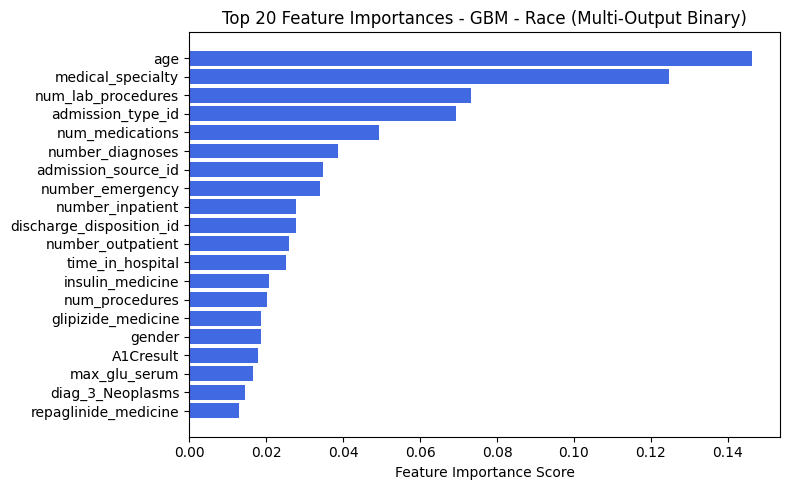

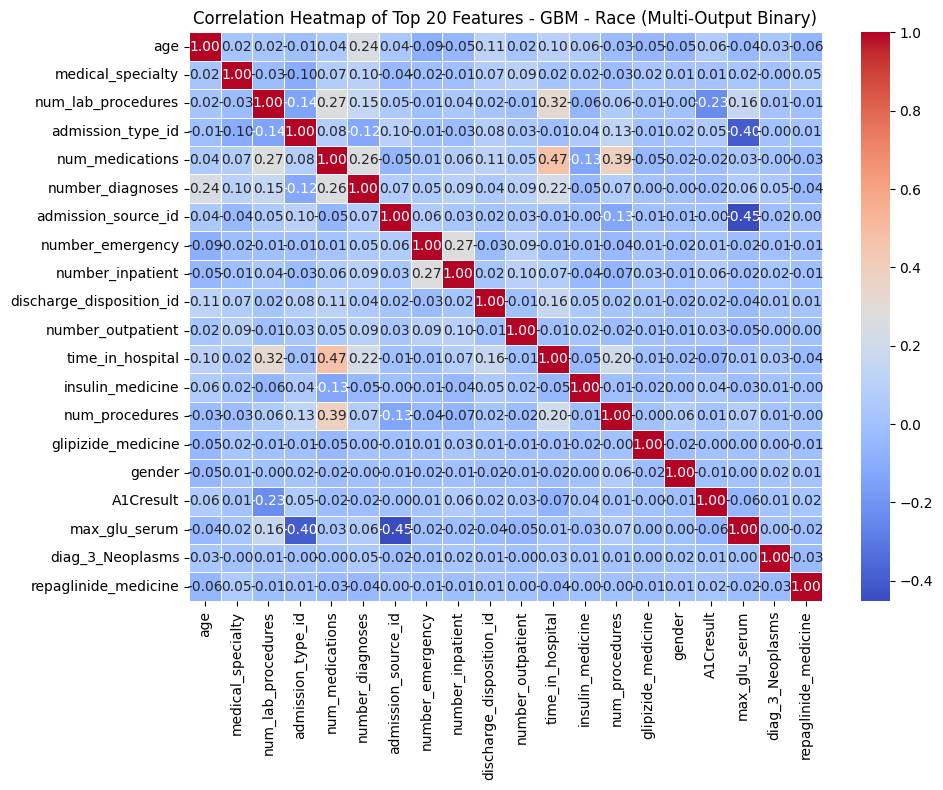

In [18]:
# 2) Multi-output (separate binary columns)
X_race_multi = df.drop(
    [
        'race',
        'race_AfricanAmerican',
        'race_Asian',
        'race_Caucasian',
        'race_Hispanic',
        'race_Other',
        'readmitted' 
    ], 
    axis=1
)

y_race_multi = df[[
    'race_AfricanAmerican',
    'race_Asian',
    'race_Caucasian',
    'race_Hispanic',
    'race_Other'
]]

gbr_multi = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)

top20_features_race_multi = evaluate_model_and_features(
    X_race_multi,
    y_race_multi,
    model=gbr_multi,
    feature_names=X_race_multi.columns,
    top=20,
    title="GBM - Race (Multi-Output Binary)",
    multi_output=True,
    average='micro'
)


## Extract most important feature in classifying readmitted, and demographics

In [29]:
all_features_related_to_demographics_readmitted = set(top20_features_race_labeling) | set(top20_features_race_multi) | set(top20_features_gender) | set(top20_features_readmitted)


columns_to_remove = {
    'readmitted', 'age', 'gender', 'race', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other', 'medical_specialty', 'admission_type_id', 'admission_source_id'
}

all_features_related_to_demographics_readmitted = all_features_related_to_demographics_readmitted - columns_to_remove
top20_features_readmitted = set(top20_features_readmitted) - columns_to_remove

print("Number of combined features:", len(top20_features_readmitted))
print(top20_features_readmitted)


Number of combined features: 21
{'number_diagnoses', 'time_in_hospital', 'diag_3_Other', 'diag_3_Diabetes', 'diag_1_Other', 'discharge_disposition_id', 'num_medications', 'glipizide_medicine', 'diag_3_Circulatory', 'metformin_medicine', 'num_lab_procedures', 'A1Cresult', 'num_procedures', 'number_outpatient', 'diag_2_Circulatory', 'number_inpatient', 'diag_2_Other', 'number_emergency', 'diag_1_Circulatory', 'insulin_medicine', 'change'}


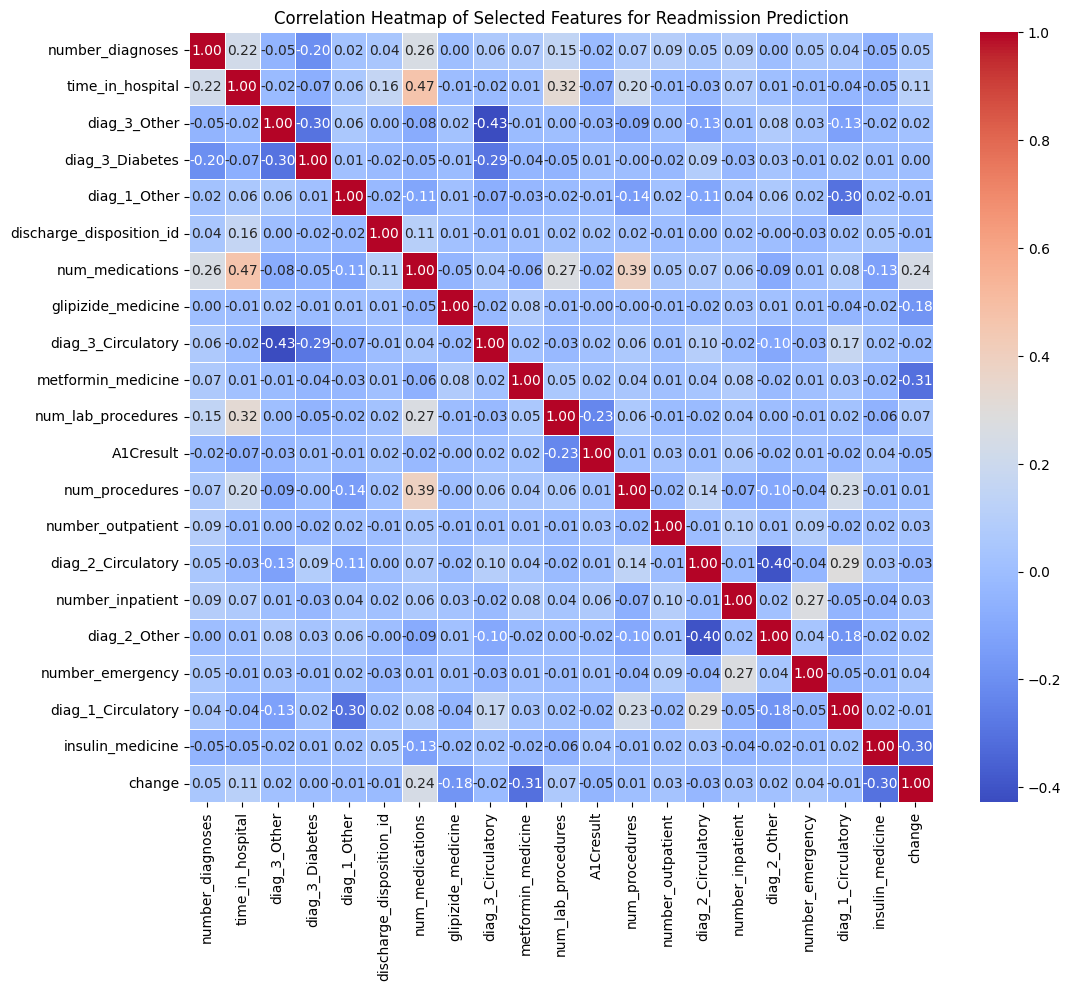

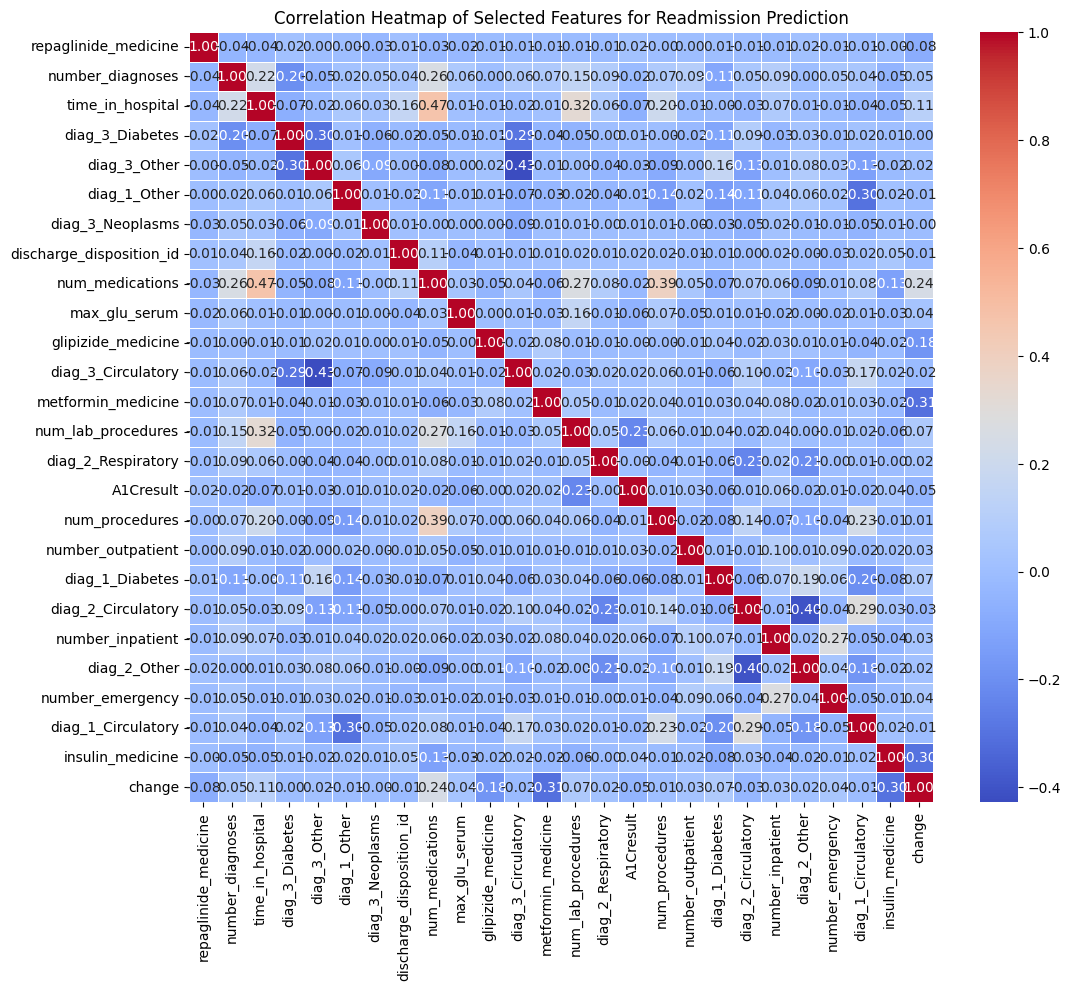

In [30]:
selected_columns_cherry_picked = df[list(top20_features_readmitted)]
selected_columns_all_demographics = df[list(all_features_related_to_demographics_readmitted)]

correlation_matrix_cherry_picked = selected_columns_cherry_picked.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_cherry_picked, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features for Readmission Prediction")
plt.show()

correlation_matrix_all = selected_columns_all_demographics.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features for Readmission Prediction")
plt.show()

In [31]:
#create a list of columns including columns with high importance, readmitted, and missed demographics
selected_columns_cherry_picked = list(selected_columns_cherry_picked) + ['readmitted', 'race', 'gender', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other']
print(selected_columns_cherry_picked)

selected_columns_all_demographics = list(selected_columns_all_demographics) + ['readmitted', 'race', 'gender', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other']
print(selected_columns_all_demographics)

['number_diagnoses', 'time_in_hospital', 'diag_3_Other', 'diag_3_Diabetes', 'diag_1_Other', 'discharge_disposition_id', 'num_medications', 'glipizide_medicine', 'diag_3_Circulatory', 'metformin_medicine', 'num_lab_procedures', 'A1Cresult', 'num_procedures', 'number_outpatient', 'diag_2_Circulatory', 'number_inpatient', 'diag_2_Other', 'number_emergency', 'diag_1_Circulatory', 'insulin_medicine', 'change', 'readmitted', 'race', 'gender', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other']
['repaglinide_medicine', 'number_diagnoses', 'time_in_hospital', 'diag_3_Diabetes', 'diag_3_Other', 'diag_1_Other', 'diag_3_Neoplasms', 'discharge_disposition_id', 'num_medications', 'max_glu_serum', 'glipizide_medicine', 'diag_3_Circulatory', 'metformin_medicine', 'num_lab_procedures', 'diag_2_Respiratory', 'A1Cresult', 'num_procedures', 'number_outpatient', 'diag_1_Diabetes', 'diag_2_Circulatory', 'number_inpatient', 'diag_2_Other', 'number_emergency', 'diag_1_Circu

In [32]:
df_extracted_features_cherry_picked = df[selected_columns_cherry_picked]

df_extracted_features_cherry_picked.columns = [col.replace("-", "_") for col in df_extracted_features_cherry_picked.columns]

df_extracted_features_cherry_picked.head()
df_extracted_features_cherry_picked.info()

selected_columns_all_demographics = df[selected_columns_all_demographics]

selected_columns_all_demographics.columns = [col.replace("-", "_") for col in selected_columns_all_demographics.columns]


<class 'pandas.core.frame.DataFrame'>
Index: 88458 entries, 0 to 10148
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   number_diagnoses          88458 non-null  int64
 1   time_in_hospital          88458 non-null  int64
 2   diag_3_Other              88458 non-null  int64
 3   diag_3_Diabetes           88458 non-null  int64
 4   diag_1_Other              88458 non-null  int64
 5   discharge_disposition_id  88458 non-null  int64
 6   num_medications           88458 non-null  int64
 7   glipizide_medicine        88458 non-null  int64
 8   diag_3_Circulatory        88458 non-null  int64
 9   metformin_medicine        88458 non-null  int64
 10  num_lab_procedures        88458 non-null  int64
 11  A1Cresult                 88458 non-null  int64
 12  num_procedures            88458 non-null  int64
 13  number_outpatient         88458 non-null  int64
 14  diag_2_Circulatory        88458 non-null  i

In [33]:
for col in df_extracted_features_cherry_picked.columns:
    print(f"--- {col} ---")
    print(f"Unique values: {df_extracted_features_cherry_picked[col].nunique()}")
    print(f"Min: {df_extracted_features_cherry_picked[col].min()}")
    print(f"Max: {df_extracted_features_cherry_picked[col].max()}")
    print(f"Mean: {df_extracted_features_cherry_picked[col].mean()}")
    print("-" * 50)

--- number_diagnoses ---
Unique values: 16
Min: 1
Max: 16
Mean: 7.431063329489701
--------------------------------------------------
--- time_in_hospital ---
Unique values: 14
Min: 1
Max: 14
Mean: 4.410432069456691
--------------------------------------------------
--- diag_3_Other ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.30236948608379116
--------------------------------------------------
--- diag_3_Diabetes ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.1675597458680956
--------------------------------------------------
--- diag_1_Other ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.17959935788735898
--------------------------------------------------
--- discharge_disposition_id ---
Unique values: 26
Min: 1
Max: 28
Mean: 3.7431097243889755
--------------------------------------------------
--- num_medications ---
Unique values: 75
Min: 1
Max: 81
Mean: 16.00159397680255
--------------------------------------------------
--- glipizide_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 2.64504

In [34]:
for col in selected_columns_all_demographics.columns:
    print(f"--- {col} ---")
    print(f"Unique values: {selected_columns_all_demographics[col].nunique()}")
    print(f"Min: {selected_columns_all_demographics[col].min()}")
    print(f"Max: {selected_columns_all_demographics[col].max()}")
    print(f"Mean: {selected_columns_all_demographics[col].mean()}")
    print("-" * 50)

--- repaglinide_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 2.9539216351262745
--------------------------------------------------
--- number_diagnoses ---
Unique values: 16
Min: 1
Max: 16
Mean: 7.431063329489701
--------------------------------------------------
--- time_in_hospital ---
Unique values: 14
Min: 1
Max: 14
Mean: 4.410432069456691
--------------------------------------------------
--- diag_3_Diabetes ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.1675597458680956
--------------------------------------------------
--- diag_3_Other ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.30236948608379116
--------------------------------------------------
--- diag_1_Other ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.17959935788735898
--------------------------------------------------
--- diag_3_Neoplasms ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.01968165683149065
--------------------------------------------------
--- discharge_disposition_id ---
Unique values: 26
Min: 1
Max: 28
Mean: 3.74

In [35]:
file_path = r'dataset/train_test_extracted_oversample/train_test_extracted_oversample_cherry_picked.csv'

df_extracted_features_cherry_picked.to_csv(file_path, index=False)

print(f"file has been saved in {file_path}.")

file has been saved in dataset/train_test_extracted_oversample/train_test_extracted_oversample_cherry_picked.csv.


In [36]:
file_path = r'dataset/train_test_extracted_oversample/train_test_extracted_oversample_all_demographics.csv'

selected_columns_all_demographics.to_csv(file_path, index=False)

print(f"file has been saved in {file_path}.")

file has been saved in dataset/train_test_extracted_oversample/train_test_extracted_oversample_all_demographics.csv.
